# Deep Learning
## HW2 - Problem 2

Name: Amin Robatian

Student Number: 400301075

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Lambda
import pandas as pd
import random
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from math import floor

%matplotlib inline

torch.manual_seed(30)
random.seed(30)
np.random.seed(30)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DL HW2/

Mounted at /content/drive
/content/drive/MyDrive/DL HW2


# Part (A) - Data Uploading

In [3]:
df = pd.read_csv('international_matches.csv')
df.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


# Part (B) - Scatter Plot of the Data

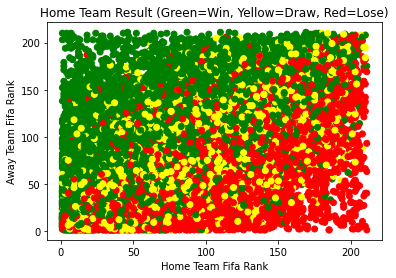

In [4]:
x = df['home_team_fifa_rank']
y = df['away_team_fifa_rank']
colors = df['home_team_result']
colors = colors.replace('Win', 'green')
colors = colors.replace('Draw', 'yellow')
colors = colors.replace('Lose', 'red')


plt.scatter(x, y, c=colors)
plt.xlabel('Home Team Fifa Rank')
plt.ylabel('Away Team Fifa Rank')
plt.title('Home Team Result (Green=Win, Yellow=Draw, Red=Lose)')
plt.show()

# Part (C) - Data Sorting

In [5]:
df_modified = df[['home_team_fifa_rank', 'away_team_fifa_rank',
                  'home_team_total_fifa_points', 'away_team_total_fifa_points',
                  'home_team_result']]

df_modified = df_modified[df_modified.home_team_total_fifa_points != 0]
df_modified = df_modified[df_modified.away_team_total_fifa_points != 0]

In [6]:
df_modified = df_modified.reset_index()
train_df = df_modified[:floor(0.75 * len(df_modified))]
test_df = df_modified[floor(0.75 * len(df_modified)):]

# Part (D) - Correlation of Features

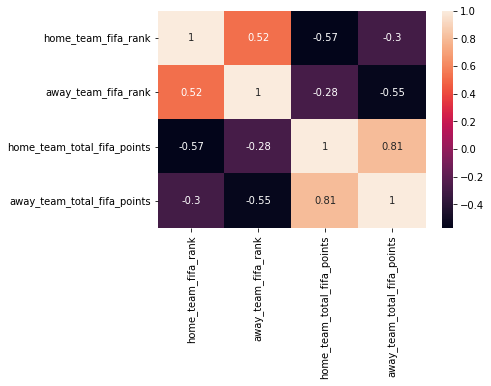

In [7]:
df_features = df_modified[['home_team_fifa_rank', 'away_team_fifa_rank',
                  'home_team_total_fifa_points', 'away_team_total_fifa_points']]
corr = df_features.corr() # Correlation between features
hm = sn.heatmap(data = corr, annot=True)
plt.show()

# Part (E) - Network Architecture Design

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
            nn.ReLU()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        y = F.softmax(logits, dim=1)
        return y

In [9]:
# creating an instance of our model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
    (7): ReLU()
  )
)


# Part (F) - Model Training & Testing

In [10]:
learning_rate = 1e-1
batch_size = 64
epochs = 20

In [11]:
df_modified = df_modified.replace({'home_team_result':{'Lose':0, 'Draw':1, 'Win':2}})
train_df = train_df.replace({'home_team_result':{'Lose':0, 'Draw':1, 'Win':2}})
test_df = test_df.replace({'home_team_result':{'Lose':0, 'Draw':1, 'Win':2}})

In [12]:
df_modified_mean = df_modified.mean()
df_modified_std = df_modified.std()

In [13]:
train_df_normalized = (train_df - train_df.mean()) / train_df.std()
train_df_normalized['home_team_result'] = train_df['home_team_result']

test_df_normalized =(test_df - test_df.mean()) / test_df.std()
test_df_normalized['home_team_result'] = test_df['home_team_result']

In [14]:
train_array = train_df_normalized.to_numpy()
test_array = test_df_normalized.to_numpy()

In [15]:
class CustomDataset(Dataset):
    def __init__(self, X_train, y_train, transform=None, target_transform=None):
      self.transform = transform
      self.target_transform = target_transform
      # need to convert float64 to float32 else 
      # will get the following error
      # RuntimeError: expected scalar type Double but found Float
      self.X = torch.from_numpy(X_train.astype(np.float32))
      # need to convert float64 to Long else 
      # will get the following error
      # RuntimeError: expected scalar type Long but found Float
      self.y = torch.from_numpy(y_train).type(torch.LongTensor)
      self.len = self.X.shape[0]
  
    def __getitem__(self, index):
      feature = self.X[index]
      if self.transform:
        feature = self.transform(self.X[index])
      label = self.y[index]
      if self.target_transform:
        label = self.target_transform(self.y[index])
      return feature, label  
    def __len__(self):
      return self.len

In [16]:
target_transform = Lambda(lambda y: torch.zeros(3, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
training_data = CustomDataset(train_array[:, 1:-1], train_array[:, -1], target_transform=target_transform)
test_data = CustomDataset(test_array[:, 1:-1], test_array[:, -1], target_transform=target_transform)

In [17]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [18]:
def TrainDataSet_Accuracy(dataloader, model, loss_fn):
    size = floor(len(dataloader.dataset) / batch_size) * batch_size
    num_batches = floor(len(dataloader.dataset) / batch_size)
    train_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            if len(X) < batch_size:
              break
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            #
            for i in range(batch_size):
              v1 = pred[i]
              v2 = y[i]
              if torch.argmax(v1) == torch.argmax(v2):
                correct += 1
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size
    print(f"Train Dataset: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

In [19]:
def TestDataSet_Accuracy(dataloader, model, loss_fn):
    size = floor(len(dataloader.dataset) / batch_size) * batch_size
    num_batches = floor(len(dataloader.dataset) / batch_size)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            if len(X) < batch_size:
              break
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #
            for i in range(batch_size):
              v1 = pred[i]
              v2 = y[i]
              if torch.argmax(v1) == torch.argmax(v2):
                correct += 1
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Dataset: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train()
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.eval()
    TrainDataSet_Accuracy(train_dataloader, model, loss_fn)
    TestDataSet_Accuracy(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


<ipython-input-16-7c12f4c8b0a9>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform = Lambda(lambda y: torch.zeros(3, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),


Train Dataset: 
 Accuracy: 48.5%, Avg loss: 1.059937 

Test Dataset: 
 Accuracy: 48.9%, Avg loss: 1.058138 

Epoch 2
-------------------------------
Train Dataset: 
 Accuracy: 48.4%, Avg loss: 1.048359 

Test Dataset: 
 Accuracy: 48.9%, Avg loss: 1.044179 

Epoch 3
-------------------------------
Train Dataset: 
 Accuracy: 48.5%, Avg loss: 1.040706 

Test Dataset: 
 Accuracy: 48.8%, Avg loss: 1.033733 

Epoch 4
-------------------------------
Train Dataset: 
 Accuracy: 48.4%, Avg loss: 1.031580 

Test Dataset: 
 Accuracy: 48.7%, Avg loss: 1.019877 

Epoch 5
-------------------------------
Train Dataset: 
 Accuracy: 48.4%, Avg loss: 1.018016 

Test Dataset: 
 Accuracy: 48.9%, Avg loss: 1.000106 

Epoch 6
-------------------------------
Train Dataset: 
 Accuracy: 48.5%, Avg loss: 1.006266 

Test Dataset: 
 Accuracy: 48.7%, Avg loss: 0.986152 

Epoch 7
-------------------------------
Train Dataset: 
 Accuracy: 50.7%, Avg loss: 0.999535 

Test Dataset: 
 Accuracy: 54.0%, Avg loss: 0.975528

In [22]:
print('Model Accuracy on Test Data \n-------------------------------\n')
TestDataSet_Accuracy(test_dataloader, model, loss_fn)
print(' \n-------------------------------')

Model Accuracy on Test Data 
-------------------------------

Test Dataset: 
 Accuracy: 60.9%, Avg loss: 0.970844 

 
-------------------------------


<ipython-input-16-7c12f4c8b0a9>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform = Lambda(lambda y: torch.zeros(3, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),


# Part (G) - Results

**Group B:**

**Iran**:

(Fifa Rank: 20, Total Fifa Points: 1564.61)

**England**:

(Fifa Rank: 5, Total Fifa Points: 1728.47)

**USA**:

(Fifa Rank: 16, Total Fifa Points: 1627.48)

**Wales**:

(Fifa Rank: 19, Total Fifa Points: 1569.82)



In [23]:
Iran_rank = 20
Iran_points = 1564.61
England_rank = 5
England_points = 1728.47
USA_rank = 16
USA_points = 1627.48
Wales_rank = 19
Wales_points = 1569.82

**Iran v.s. England**

In [24]:
feature1 = (Iran_rank - df_modified_mean[1]) / df_modified_std[1]
feature2 = (England_rank - df_modified_mean[2]) / df_modified_std[2]
feature3 = (Iran_points - df_modified_mean[3]) / df_modified_std[3]
feature4 = (England_points - df_modified_mean[4]) / df_modified_std[4]

In [25]:
feature_array = np.array([feature1, feature2, feature3, feature4])
feature_tensor = torch.from_numpy(feature_array.astype(np.float32))
feature_tensor = torch.reshape(feature_tensor, (1, 4))
feature_tensor = feature_tensor.to(device)
with torch.no_grad():
  pred = model(feature_tensor)

print(f"The chance of Iran winning against England: {(100*pred[0, 2]):>0.1f}%")

The chance of Iran winning against England: 33.3%


**Iran v.s. USA**

In [26]:
feature1 = (Iran_rank - df_modified_mean[1]) / df_modified_std[1]
feature2 = (USA_rank - df_modified_mean[2]) / df_modified_std[2]
feature3 = (Iran_points - df_modified_mean[3]) / df_modified_std[3]
feature4 = (USA_points - df_modified_mean[4]) / df_modified_std[4]

In [27]:
feature_array = np.array([feature1, feature2, feature3, feature4])
feature_tensor = torch.from_numpy(feature_array.astype(np.float32))
feature_tensor = torch.reshape(feature_tensor, (1, 4))
feature_tensor = feature_tensor.to(device)
with torch.no_grad():
  pred = model(feature_tensor)

print(f"The chance of Iran winning against USA: {(100*pred[0, 2]):>0.1f}%")

The chance of Iran winning against USA: 53.7%


**Iran v.s. Wales**

In [28]:
feature1 = (Iran_rank - df_modified_mean[1]) / df_modified_std[1]
feature2 = (Wales_rank - df_modified_mean[2]) / df_modified_std[2]
feature3 = (Iran_points - df_modified_mean[3]) / df_modified_std[3]
feature4 = (Wales_points - df_modified_mean[4]) / df_modified_std[4]

In [29]:
feature_array = np.array([feature1, feature2, feature3, feature4])
feature_tensor = torch.from_numpy(feature_array.astype(np.float32))
feature_tensor = torch.reshape(feature_tensor, (1, 4))
feature_tensor = feature_tensor.to(device)
with torch.no_grad():
  pred = model(feature_tensor)

print(f"The chance of Iran winning against Wales: {(100*pred[0, 2]):>0.1f}%")

The chance of Iran winning against Wales: 66.7%
